# Youtube Video Analysis
by Guan Ming Chiu (b10101053@ntu.edu.tw)

## 1. Data Preparation

### 1.1 Data Fetch

**Method of Obtaining and Processing Data** 
- All data are obtained from YouTube Search API v3.
- Only videos uploaded between 01/01/2023 and 31/05/2023 are chosen in order to ensure the comparability (by controlling the exposure time).

In [1]:
import requests, isodate
from googleapiclient.discovery import build
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from wordcloud import WordCloud


DEVELOPER_KEY = 

def youtube_search(loopTimes = 1):
    youtube = build('youtube','v3',developerKey=DEVELOPER_KEY)
    token = None
    df = pd.DataFrame()
    
    for i in range(loopTimes):
        search_response = youtube.search().list(
            type="video",
            pageToken=token,
            order="viewCount",
            part="id,snippet",
            publishedAfter='2023-01-01T00:00:00Z',
            publishedBefore='2023-05-31T23:59:59Z',
            maxResults=100
        ).execute()
        
        localVidList = []
        
        for search_result in search_response.get("items", []):
            if search_result["id"]["kind"] == "youtube#video":
                localVidList.append(search_result['id']['videoId'])
        
        id_str = ",".join(localVidList);
        
        list_response = youtube.videos().list(
            part='statistics, snippet, contentDetails',
            id=id_str).execute()
        
        # print('Finished: ' + str(i+1) + '/' + str(loopTimes+1))
        
        
        if "nextPageToken" in search_response:
            token = search_response['nextPageToken']
        else:
            print('No more data.')
            break

        df_cur = pd.DataFrame(data=list_response['items'])
        if i == 0:
            df = df_cur
        else:
            df = df.append(df_cur)

    return df


In [2]:
res = youtube_search(20)

/var/folders/y5/6359zjqj4t5gm6_3sh8v9sdh0000gn/T/ipykernel_75321/2554780069.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_cur)
/var/folders/y5/6359zjqj4t5gm6_3sh8v9sdh0000gn/T/ipykernel_75321/2554780069.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_cur)
/var/folders/y5/6359zjqj4t5gm6_3sh8v9sdh0000gn/T/ipykernel_75321/2554780069.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_cur)
/var/folders/y5/6359zjqj4t5gm6_3sh8v9sdh0000gn/T/ipykernel_75321/2554780069.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_cur)
/var/folders/y5/6359zjqj4t5gm6_3sh8v

No more data.


### 1.2 Data Cleaning

In [3]:
df = pd.DataFrame(data=res)
df = df[df.kind == 'youtube#video']
df = df.drop(columns='kind')
df = df.drop(columns='etag')
df = df.drop(columns='id')

df['title'] = df['snippet'].apply(lambda x: x['title'])
df['categoryId'] = df['snippet'].apply(lambda x: x['categoryId'])
df['description'] = df['snippet'].apply(lambda x: x['description'])
df = df.drop(columns='snippet')

df['duration'] = df['contentDetails'].apply(lambda x: isodate.parse_duration(x['duration']).total_seconds())
df = df.drop(columns='contentDetails')

df['viewCount'] = df['statistics'].apply(lambda x: x.get('viewCount', np.nan))
df['likeCount'] = df['statistics'].apply(lambda x: x.get('likeCount', np.nan))
df['commentCount'] = df['statistics'].apply(lambda x: x.get('commentCount', np.nan))
df['favoriteCount'] = df['statistics'].apply(lambda x: x['favoriteCount'])
df = df.drop(columns='statistics')

catId2NameDict = {
    '1': 'Film & Animation', '2': 'Autos & Vehicles',
    '10': 'Music', '15': 'Pets & Animals', '17': 'Sports', '18': 'Short Movies', '19': 'Travel & Events',
    '20': 'Gaming', '21': 'Videoblogging', '22': 'People & Blogs', '23': 'Comedy', '24': 'Entertainment', '25': 'News & Politics', '26': 'Howto & Style', '27': 'Education', '28': 'Science & Technology', '29': 'Nonprofits & Activism',
    '30': 'Movies', '31': 'Anime/Animation', '32': 'Action/Adventure', '33': 'Classics', '34': 'Comedy', '35': 'Documentary', '36': 'Drama', '37': 'Family', '38': 'Foreign', '39': 'Horror',
    '40': 'Sci-Fi/Fantasy', '41': 'Thriller', '42': 'Shorts', '43': 'Shows', '44': 'Trailers'
}

df['categoryName'] = df['categoryId'].map(catId2NameDict)

# df = df[df.categoryId != 1]
# df = df[df.categoryId != 10]

df = df.reset_index(drop=True)
df.head()


,title,categoryId,description,duration,viewCount,likeCount,commentCount,favoriteCount,categoryName
0,萌娃貪玩，衣服被卡住了，哥哥趕快來救她#萌娃#兒童鍛煉#熊孩子#搞笑#兒童安全#營救,22,萌娃貪玩，衣服被卡住了，哥哥趕快來救她#萌娃#兒童鍛煉#熊孩子#搞笑\n大家好，這裡是男幼師...,35.0,98065327,1279469,1976,0,People & Blogs
1,#补鞋胶 家里面鞋子脱胶别着急扔，试试这款补鞋胶,22,https://amzn.to/3nQhG62,20.0,87083957,794772,715,0,People & Blogs
2,奇軒隨機向路人展示後空翻，結果被打了！,1,,49.0,79422880,2185758,5577,0,Film & Animation
3,⚡⚡📱💥danger！! Brave dog helps child! Dogs are o...,24,,26.0,66917090,891293,1421,0,Entertainment
4,Wait for it #youtubeshorts #deepakkoul #trendi...,22,,24.0,61588272,1188064,2460,0,People & Blogs


### 1.3 Data Description

In [4]:
df.info()
df = df.dropna()
df['favoriteCount'] = df['favoriteCount'].astype('int64')
df['likeCount'] = df['likeCount'].astype('int64')
df['viewCount'] = df['viewCount'].astype('int64')
df['commentCount'] = df['commentCount'].astype('int64')
# df = df[~df['title'].str.contains('#short')]
# df = df[df['title'].str.contains('#short')]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          550 non-null    object 
 1   categoryId     550 non-null    object 
 2   description    550 non-null    object 
 3   duration       550 non-null    float64
 4   viewCount      549 non-null    object 
 5   likeCount      540 non-null    object 
 6   commentCount   530 non-null    object 
 7   favoriteCount  550 non-null    object 
 8   categoryName   550 non-null    object 
dtypes: float64(1), object(8)
memory usage: 38.8+ KB


/var/folders/y5/6359zjqj4t5gm6_3sh8v9sdh0000gn/T/ipykernel_75321/1160349829.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


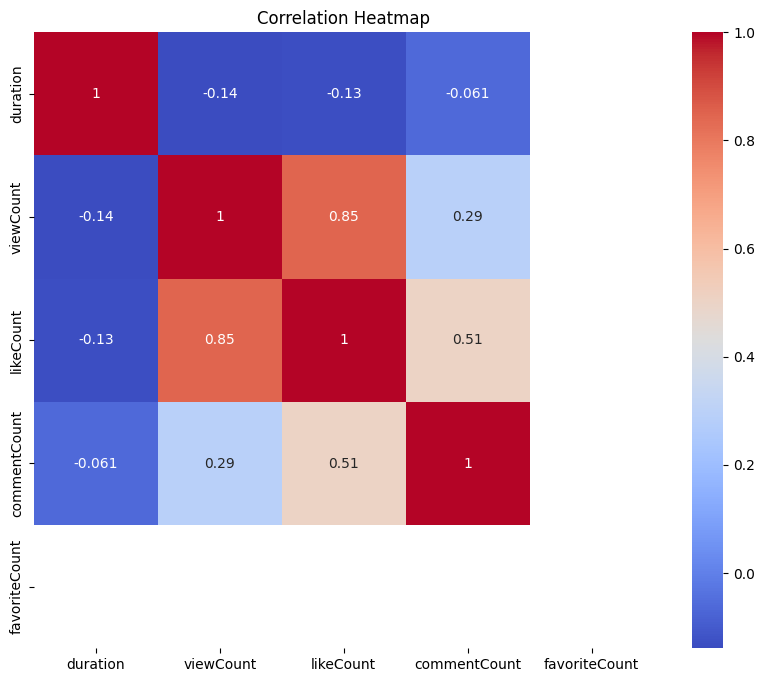

In [5]:
# Create a correlation matrix
corr_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## 2. Exporatory Data Analysis 

### 2.1 Video Duration Analysis

In [6]:
def avgDurCounter(df, unit=10):
    avgDurArr = []
    for i in range(unit, df.shape[0], unit):
        avgDur = 0
        for j in range(unit):
            avgDur += df.iloc[i + j - unit]['duration']
        avgDur /= unit
        avgDurArr.append(round(avgDur, 2))
    return avgDurArr

def plotDurData(df, unit=10, title=''):
    avgDurArr = avgDurCounter(df, unit)
    avgTitleArr = []
    for i in range(unit, df.shape[0], unit):
        avgTitleArr.append(f"{str(i - unit + 1)} ~ {str(i)}")
    dfb = pd.DataFrame({'Rank': avgTitleArr, 'Average Duration (s)': avgDurCounter(df, unit)})
    
    # Plotting the bar chart with custom rotation angle for x-labels
    ax = dfb.plot.bar(x='Rank', y='Average Duration (s)', rot=45, title=title, figsize=(14, 6))
    ax.set_xlabel('Rank', labelpad=10)  # Adjust the x-label padding if needed
    ax.set_ylabel('Average Duration (s)')
    plt.tight_layout()  # Ensures tight layout to prevent overlapping elements
    
    plt.show()

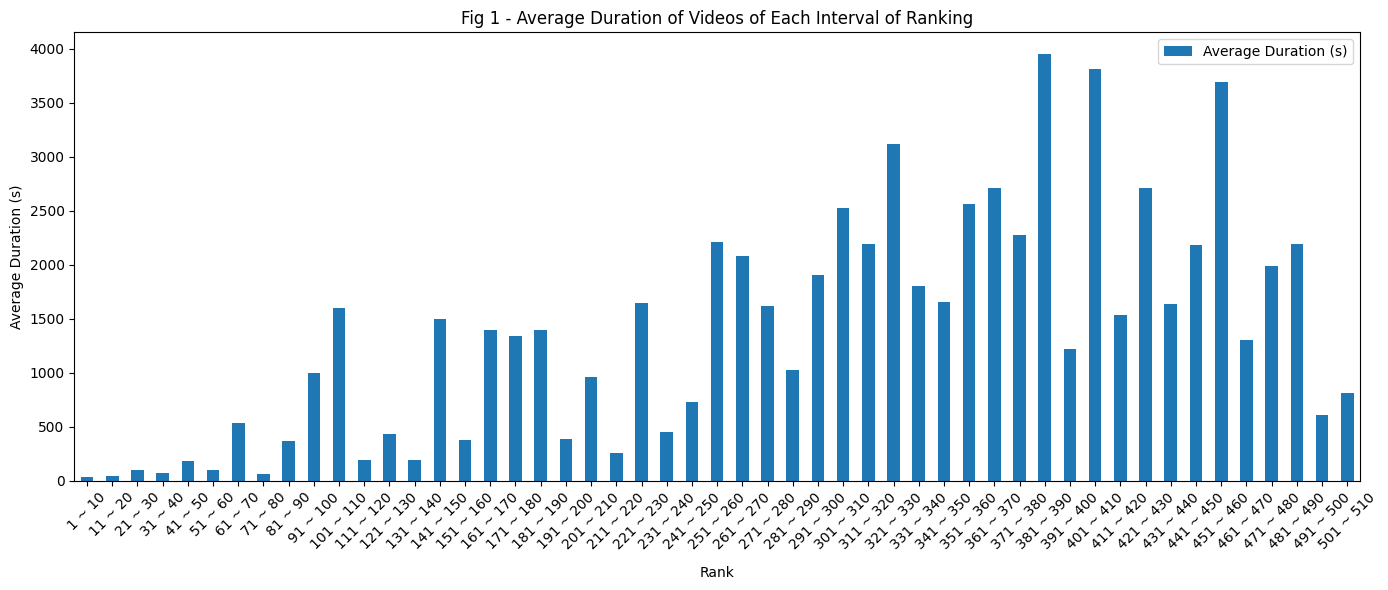

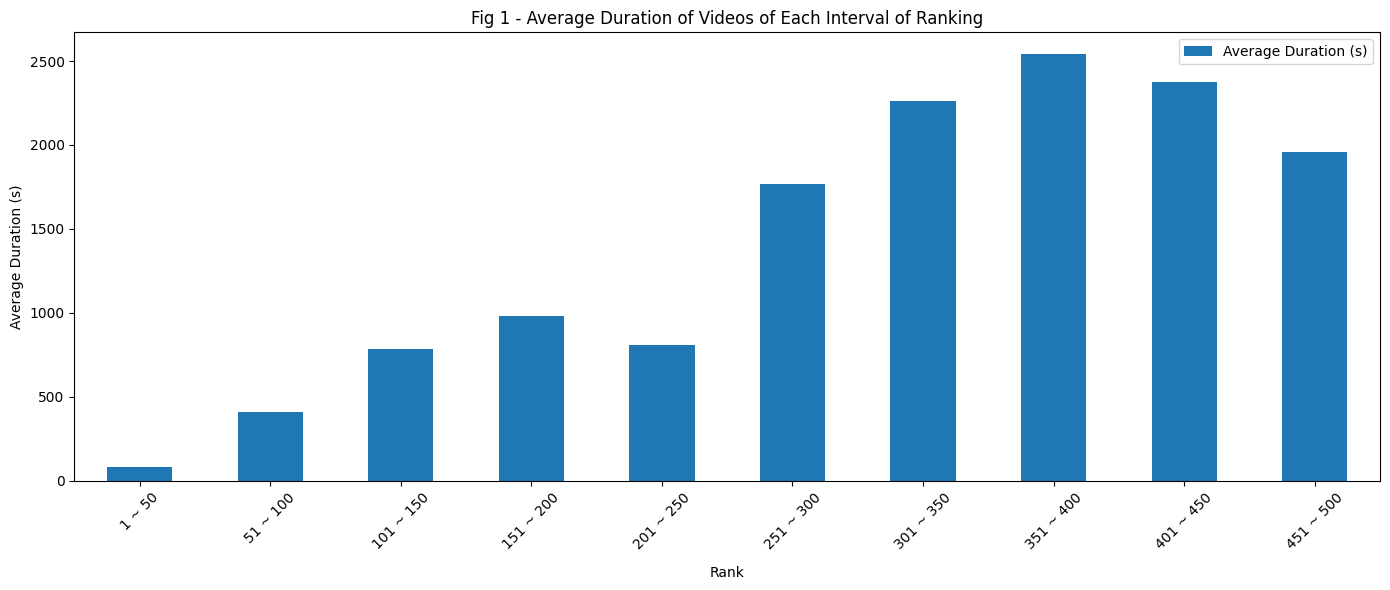

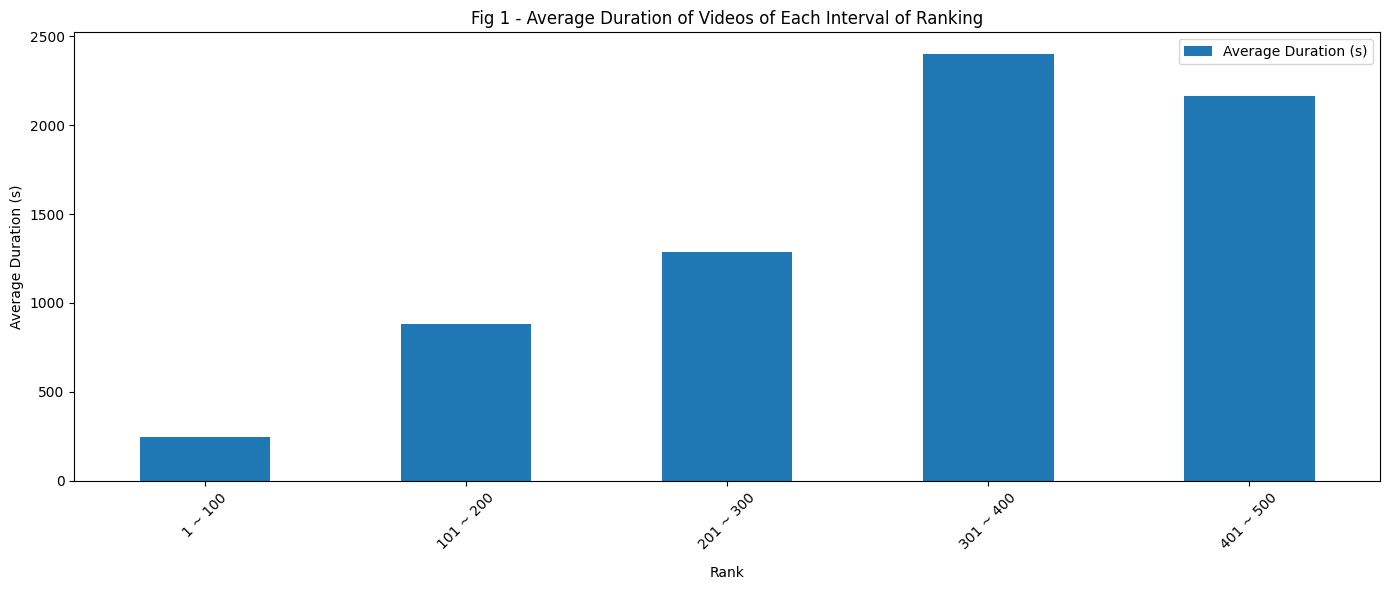

In [7]:
plotDurData(df, 10, 'Fig 1 - Average Duration of Videos of Each Interval of Ranking')
plotDurData(df, 50, 'Fig 1 - Average Duration of Videos of Each Interval of Ranking')
plotDurData(df, 100, 'Fig 1 - Average Duration of Videos of Each Interval of Ranking')

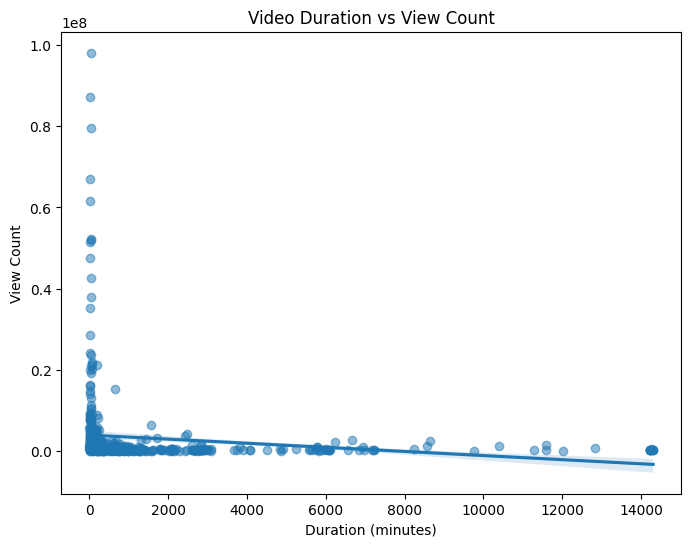

Duration Mean: 1406.5279383429672
Duration Standard Deviation: 2705.719161369579
View Count Mean: 3285697.16955684
View Count Standard Deviation: 9834811.512875117
Duration vs. View Count: Correlation = -0.13903025633171784
Regression Coefficient: -505.3504388522864
Regression Intercept: 3996486.68045646


In [8]:
# Calculate statistics
duration_mean = df['duration'].mean()
duration_std = df['duration'].std()
view_count_mean = df['viewCount'].mean()
view_count_std = df['viewCount'].std()

# Scatter plot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(x=df['duration'], y=df['viewCount'], scatter_kws={'alpha': 0.5})
plt.xlabel('Duration (minutes)')
plt.ylabel('View Count')
plt.title('Video Duration vs View Count')
plt.show()

# Calculate correlation coefficient
duration_view_corr = df['duration'].corr(df['viewCount'])

# Perform linear regression
X = df['duration'].values.reshape(-1, 1)
y = df['viewCount'].values.reshape(-1, 1)
regression_model = LinearRegression()
regression_model.fit(X, y)
regression_coef = regression_model.coef_[0][0]
regression_intercept = regression_model.intercept_[0]

# Print statistics and regression results
print(f"Duration Mean: {duration_mean}")
print(f"Duration Standard Deviation: {duration_std}")
print(f"View Count Mean: {view_count_mean}")
print(f"View Count Standard Deviation: {view_count_std}")
print(f"Duration vs. View Count: Correlation = {duration_view_corr}")
print(f"Regression Coefficient: {regression_coef}")
print(f"Regression Intercept: {regression_intercept}")


### 2.2 Category Analysis

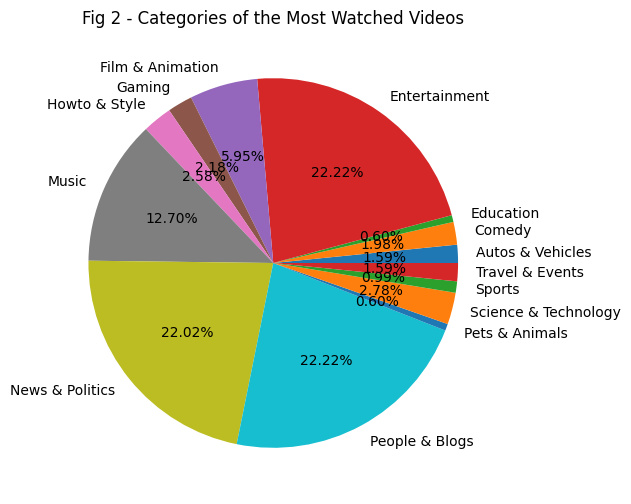

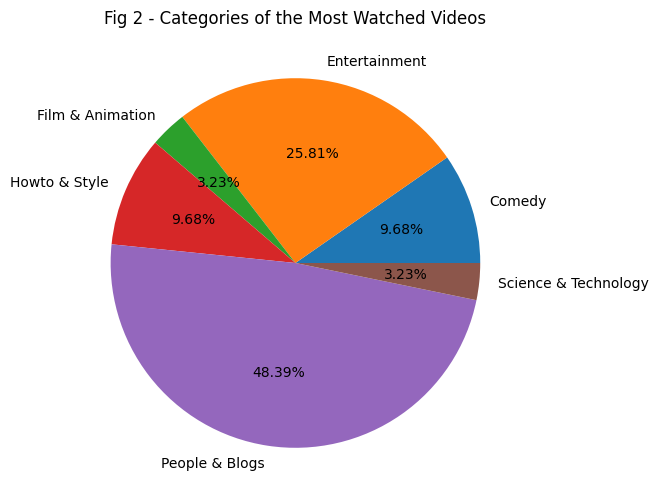

In [9]:
def plotCatData(viewLimit = 0):
    df1 = df[df.viewCount >= viewLimit]
    def autoPct(pct):
        return f'{pct:.2f}%'

    pie = df1.groupby(['categoryName']).count().plot.pie(
        y='categoryId', autopct=autoPct, fontsize=10, figsize=(10, 6), 
        title='Fig 2 - Categories of the Most Watched Videos'
    )
    pie.axes.get_yaxis().set_visible(False)
    pie.get_legend().remove()
    plt.show()

plotCatData(100000)
plotCatData(10000000)


In [10]:
df['views_per_duration'] = df['viewCount'] / df['duration']
df['likes_per_view'] = df['likeCount'] / df['viewCount']
df['comments_per_view'] = df['commentCount'] / df['viewCount']
category_group = df.groupby('categoryName')

category_stats = category_group.agg({
    'views_per_duration': 'mean',
    'likes_per_view': 'mean',
    'comments_per_view': 'mean'
})

top_categories = category_stats.nlargest(5, 'views_per_duration')

for category in top_categories.index:
    top_videos = df[df['categoryName'] == category].nlargest(5, 'viewCount')
    print(f"Top videos in the {category} category:")
    display(top_videos[['title', 'duration', 'viewCount', 'likeCount', 'commentCount']])
    print()


Top videos in the Comedy category:


,title,duration,viewCount,likeCount,commentCount
12,隔空調情 學會了嗎？ #眾量級crowd #情侶,18.0,28635065,597123,659
14,Magical Drawings,20.0,24128525,435210,289
31,anyone as well?,29.0,10696009,532382,3972
38,Help people 🙏🇦🇲❤️ #shorts #help #social,25.0,8616200,237055,2550
41,Iska Bhi Kapra Faar Do 😂😂 #funny #comedy #shor...,30.0,8238733,146499,246



Top videos in the People & Blogs category:


,title,duration,viewCount,likeCount,commentCount
0,萌娃貪玩，衣服被卡住了，哥哥趕快來救她#萌娃#兒童鍛煉#熊孩子#搞笑#兒童安全#營救,35.0,98065327,1279469,1976
1,#补鞋胶 家里面鞋子脱胶别着急扔，试试这款补鞋胶,20.0,87083957,794772,715
4,Wait for it #youtubeshorts #deepakkoul #trendi...,24.0,61588272,1188064,2460
6,Шаффл Баттл 😎🔥 Who Win 🤔 LITTLE BOY VS TUZELIT...,34.0,52187885,2399042,30829
5,TEACHING SHUFFLE ⭐️ 16 000 000 SUBS! 😱🔥 TUZEL...,23.0,51446907,2066844,2468



Top videos in the Howto & Style category:


,title,duration,viewCount,likeCount,commentCount
11,Safety shoe function test . #workshoes#shorts ...,15.0,35193942,506042,793
15,风吹入帘里，惟有惹衣香。#flowerarrangement #flowermaking #...,60.0,21921767,415154,833
34,Ikin Gold Hair Remover Creme Ft. Mouni Roy | A...,34.0,10310196,122,3
102,今天才知道，原來切菠蘿這麼簡單，不挖眼不削皮，簡單快速又好看，真的太方便了， Life Ha...,580.0,2585860,16677,364
128,褲子長了千萬不要剪，教你2個快速收褲腿的方法，長短隨便改，沒有一點痕跡，真實用 ， Life...,626.0,1977183,18067,292



Top videos in the Pets & Animals category:


,title,duration,viewCount,likeCount,commentCount
67,狗子：我是狗但我不是傻狗…,18.0,4692354,95089,316
152,你怎麼看？男生用文具自製仿真槍，老師發現後採取激勵式教育！,27.0,1845756,59509,580
281,자꾸 내 아내를 염탐하는 개자슥.. 잘 생겨서 더 짜증납니다ㅣStray Dog Th...,329.0,561981,7047,331



Top videos in the Entertainment category:


,title,duration,viewCount,likeCount,commentCount
3,⚡⚡📱💥danger！! Brave dog helps child! Dogs are o...,26.0,66917090,891293,1421
7,"Brave dog, I love you, you are my good friend....",47.0,51892911,944924,4516
22,ASMR | Remove Huge Navel Stone Animation,60.0,21446758,429746,1477
17,"🔥Brave dog, ❤️kind lady, dog is our good frien...",33.0,20917895,410757,1678
19,"Brave dog, kind lady, you are all heroes. #dog...",57.0,20120513,361001,531


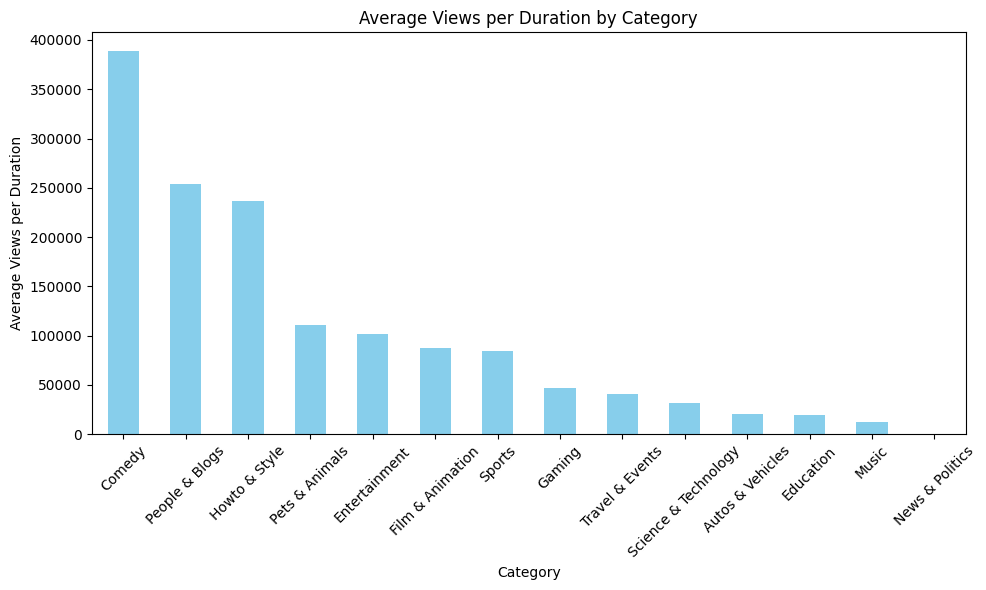

In [11]:
category_group = df.groupby('categoryName')
category_stats = category_group['views_per_duration'].mean().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
category_stats.plot(kind='bar', color='skyblue')
plt.title('Average Views per Duration by Category')
plt.xlabel('Category')
plt.ylabel('Average Views per Duration')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.3 Sentiment Analysis

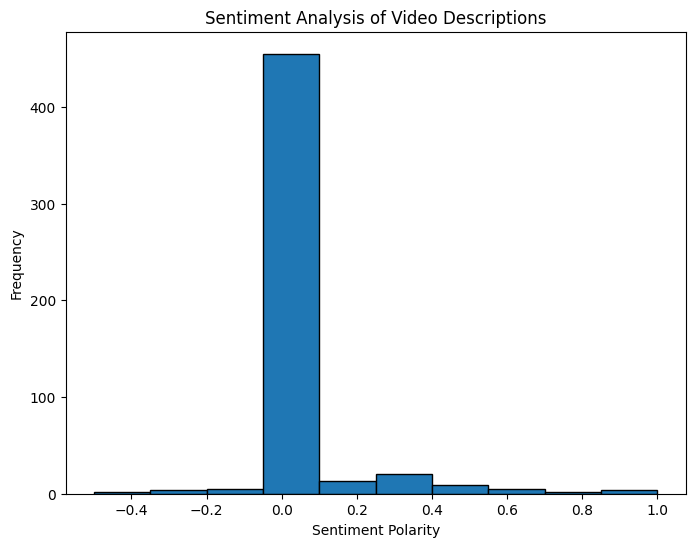

In [12]:
from textblob import TextBlob

# Perform sentiment analysis on video descriptions
df['title_sentiment'] = df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Create a histogram to visualize the sentiment distribution
plt.figure(figsize=(8, 6))
plt.hist(df['title_sentiment'], bins=10, edgecolor='black')
plt.title('Sentiment Analysis of Video Descriptions')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()


In [13]:
df['title_sentiment'].describe()

count    519.000000
mean       0.035213
std        0.147091
min       -0.500000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: title_sentiment, dtype: float64

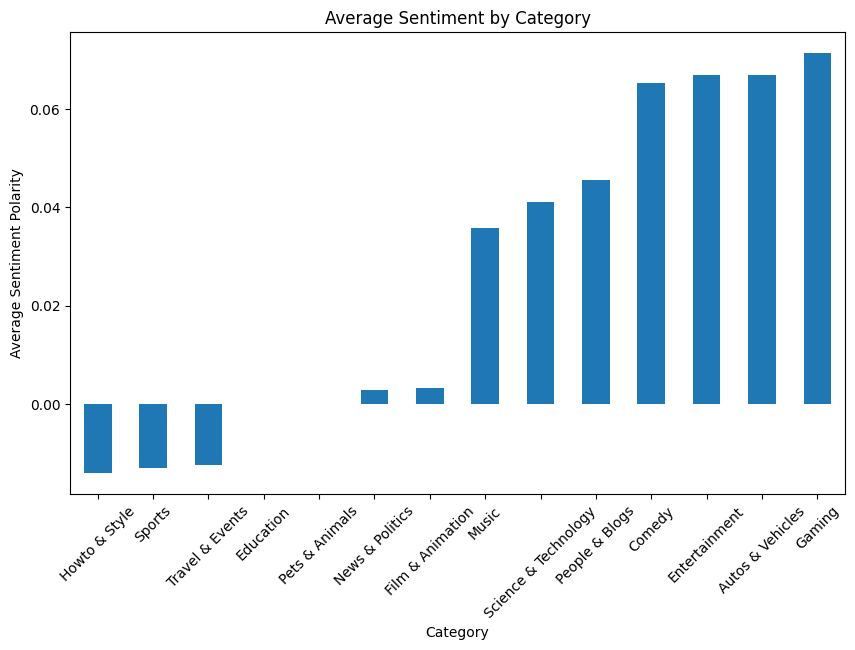

In [14]:
category_sentiment = df.groupby('categoryName')['title_sentiment'].mean().sort_values()

plt.figure(figsize=(10, 6))
category_sentiment.plot(kind='bar')
plt.title('Average Sentiment by Category')
plt.xlabel('Category')
plt.ylabel('Average Sentiment Polarity')
plt.xticks(rotation=45)
plt.show()


In [15]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

# Create a SentimentIntensityAnalyzer object
sia = SentimentIntensityAnalyzer()

# Function to extract positive words from a given text
def extract_positive_words(text):
    tokens = word_tokenize(text)
    positive_words = [word for word in tokens if sia.polarity_scores(word)['compound'] > 0]
    return positive_words

# Apply the extract_positive_words function to the 'description' column
df['positive_words'] = df['description'].apply(extract_positive_words)

# Group by category and concatenate all positive words in each category
category_positive_words = df.groupby('categoryName')['positive_words'].sum()

# Count the frequency of positive words in each category
category_positive_words


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/chiuguanming/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


categoryName
Autos & Vehicles        [GT, Challenge, GT, GT, Join, well, special, fun]
Comedy                        [cool, help, funny, Welcome, FREEst, super]
Education                                                              []
Entertainment           [credit, credit, emotional, like, Laugh, Super...
Film & Animation        [Welcome, Play, Play, Play, play, Play, Play, ...
Gaming                                     [enjoyed, like, Top, 8d, best]
Howto & Style           [safety, safety, safety, painless, solution, p...
Music                   [Happy, please, respective, Thank, Spark, Spar...
News & Politics         [Exclusive, Exclusive, Special, please, Happy,...
People & Blogs          [nice, love, creative, gift, fair, Fair, favor...
Pets & Animals                                                         []
Science & Technology    [JW, Passion, best, best, best, value, best, b...
Sports                             [exciting, Play, Free, Please, giving]
Travel & Events         [

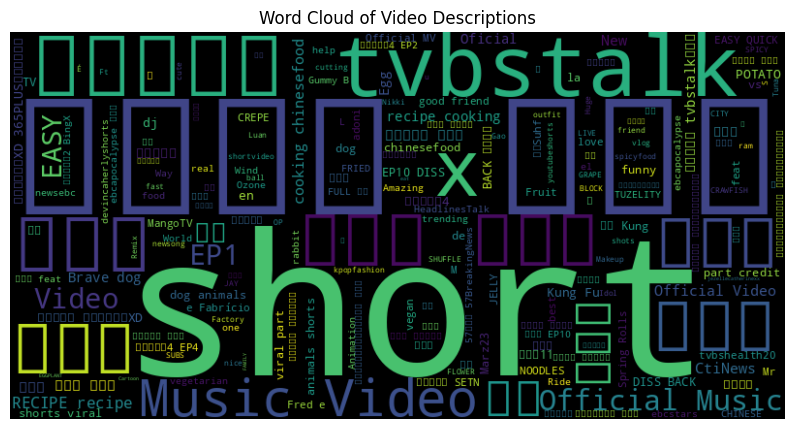

In [16]:
# Concatenate all descriptions into a single string
all_descriptions = ' '.join(df['title'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400).generate(all_descriptions)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Video Descriptions')
plt.axis('off')
plt.show()


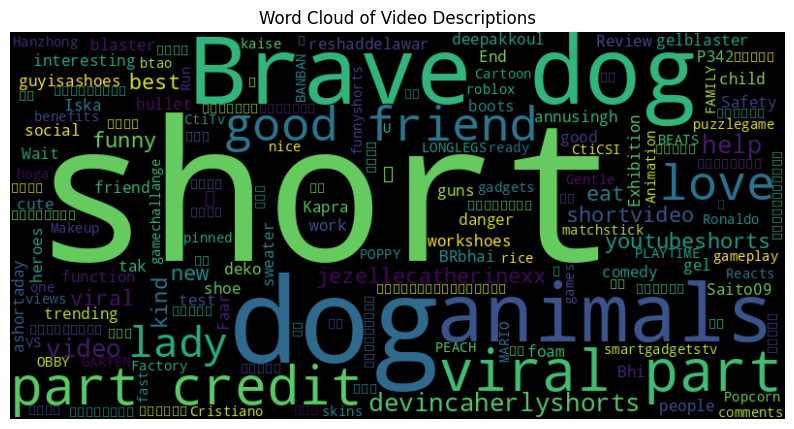

In [17]:
# Concatenate all descriptions into a single string
df_shorts = df[df['title'].str.contains('#short')]
all_descriptions = ' '.join(df_shorts['title'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400).generate(all_descriptions)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Video Descriptions')
plt.axis('off')
plt.show()


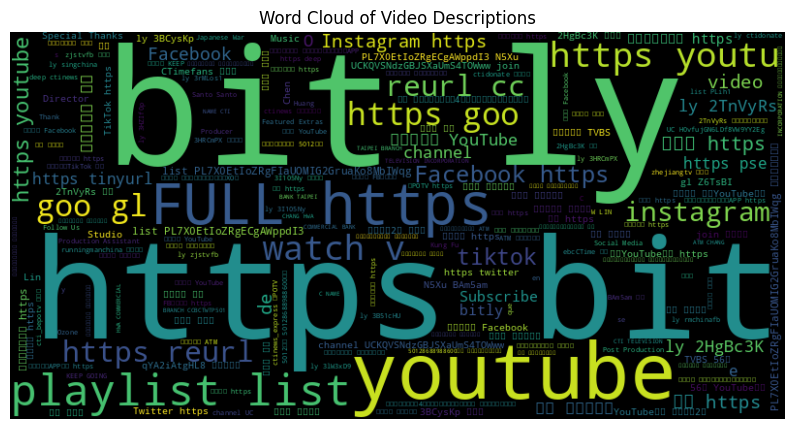

In [18]:
# Concatenate all descriptions into a single string
all_descriptions = ' '.join(df['description'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400).generate(all_descriptions)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Video Descriptions')
plt.axis('off')
plt.show()


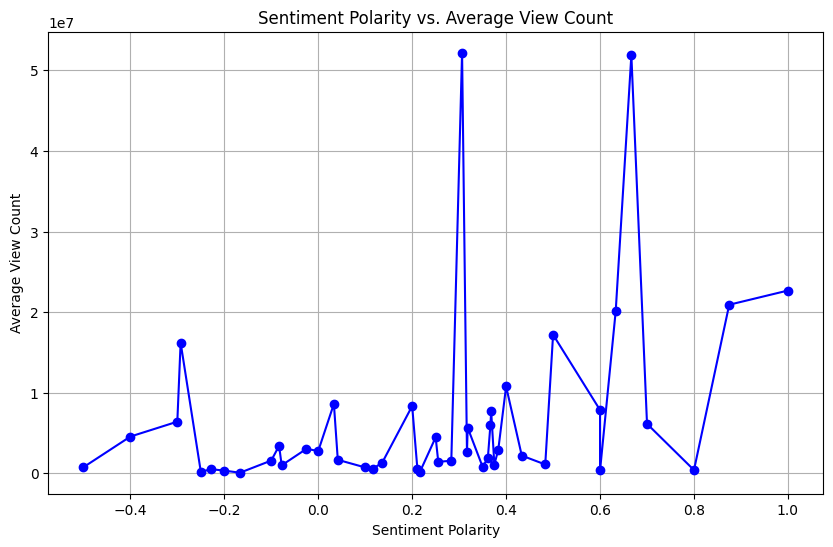

In [19]:
# Group data by sentiment polarity and calculate the average view count for each sentiment value
sentiment_avg_viewcount = df.groupby('title_sentiment')['viewCount'].mean()

# Plot sentiment polarity vs. average view count
plt.figure(figsize=(10, 6))
plt.plot(sentiment_avg_viewcount.index, sentiment_avg_viewcount.values, marker='o', linestyle='-', color='blue')
plt.title('Sentiment Polarity vs. Average View Count')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Average View Count')
plt.grid(True)
plt.show()
